In [1]:
# Import the necessary libraries
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from scipy.io import loadmat
from scipy.optimize import minimize

In [2]:
"""PLOTTING"""
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set_style("whitegrid", {'axes.grid' : False})


In [ ]:
"""Reusable Plotly method for model fitting scatter plot"""
def plot_model_fit(measured, predicted, model_name="Model", marker_size=4):
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=list(range(len(measured))),y=measured,mode='markers',name='Measured',
            marker=dict(
                size=marker_size,
                color='blue',
                opacity=0.6
            ))
    )
    fig.add_trace(
        go.Scatter(
            x=list(range(len(predicted))),y=predicted,mode='markers',name='Predicted',
            marker=dict(
                size=marker_size,
                color='red',
                opacity=0.6
            ))
    )
    fig.update_layout(
        title=model_name,xaxis_title='Measurement number',yaxis_title='Normalized Signal',showlegend=True,template='seaborn',
        width=1000,
        height=600
    )
    fig.update_yaxes(showgrid=True, gridwidth=1)

    fig.show()

: 

$\text{\large{Load Data}}$

In [ ]:
"""LOAD DWI scans"""
dwis = loadmat('data_p1/data.mat')['dwis']
dwis = np.double(dwis)
dwis = dwis.transpose((3, 0, 1, 2))
[Dc, Dx, Dy, Dz] = dwis.shape
print(dwis.shape)

"""LOAD gradient directions"""
qhat = np.loadtxt("data_p1/bvecs", delimiter = " ").T
bvals = 1000 * np.sum(qhat * qhat, axis=1)
print(qhat.shape, bvals.shape)

# Q1.1

<h3> DWIS data:</h3>
108 Image volumes: 18 with b=0 attenuation, 90 diffusion weighted. All 108 measurements have been made with a different diffusion direction, but from ONE session and ONE patient. So essentially we have 108 complete brain scan volumes from top to bottom.

Each volume is made up of 145 slices. Each slice is a 145x174 pixel IMAGE.
108x145x173x145

145: X dimension of the slice

174: Y dimension of the slice

145: Z Dimension of the slice; z-depth, i.e the number of slices in each volume.

<h3>qhat & bvecs </h3>

This is the actual gradient direction information and diffusion weighting for each of the 108 recordings. The first 18 (our baseline) are naturally directionless. The other 90 have gradient directions in bvals, and qhat has the directions.


$\Large{Q.1.1.1 }$

$\text{\large{Linear diffusion tensor estimation}}$

Must solve $A=Yx$

Where $\bold{A}$ is vector of log measurements <br>
Where $Y$ is design matrix <br>
$x$ is a vector of unknown parameters (this contains the estimated signal with no attenuation and the Diffusion Tensor)

$\text{Estimate the diffusion tensor for just one voxel first.}
\\\text{ That is, take the 108 gradient directions, the one signal value, the one diffusion weight, and estimate the D tensor.}$

In [ ]:
"""CREATE Design Matrix Y"""

def create_design_matrix(bvals, qhat):
    # Number of measurements
    n_meas = len(bvals)
    
    # Make sure qhat is properly shaped (3 x n_measurements)
    if qhat.shape[1] != n_meas:
        qhat = qhat.T
    
    # Create design matrix Y
    Y = np.zeros((n_meas, 7))
    Y[:,0] = 1  # First column is 1 for log(S0)
    
    for i in range(n_meas):
        b = bvals[i]
        q = qhat[:,i]  # Get the i-th gradient direction
        qx, qy, qz = q[0], q[1], q[2]
        
        # Fill in the row according to the design matrix formula
        Y[i,1] = -b * qx * qx
        Y[i,2] = -2 * b * qx * qy
        Y[i,3] = -2 * b * qx * qz
        Y[i,4] = -b * qy * qy
        Y[i,5] = -2 * b * qy * qz
        Y[i,6] = -b * qz * qz
    
    return Y


"""Linear Least Squares to Solve for """
def fit_diffusion_tensor(signals, bvals, qhat):
    # Take log of signals
    log_signals = np.log(signals)
    
    # Create design matrix
    Y = create_design_matrix(bvals, qhat)
    
    # Solve linear system Y x = log_signals using least squares
    x = np.linalg.lstsq(Y, log_signals, rcond=None)[0]
    
    # Construct diffusion tensor matrix
    D = np.array([[x[1], x[2], x[3]],
                  [x[2], x[4], x[5]],
                  [x[3], x[5], x[6]]])
    
    return x[0], D  # Returns log(S0) and diffusion tensor

def calculate_MD_FA(D):
    # Calculate eigenvalues
    eigenvals = np.linalg.eigvals(D)
    
    # Mean diffusivity
    MD = np.mean(eigenvals)
    
    # Fractional anisotropy
    num = np.sqrt(np.sum((eigenvals - MD)**2))
    den = np.sqrt(np.sum(eigenvals**2))
    FA = np.sqrt(3/2) * num/den if den != 0 else 0
    
    return MD, FA


In [ ]:
avox = dwis[:, 91, 64, 71]
estimated_x, estimated_d = fit_diffusion_tensor(avox, bvals, qhat)
print("Estimated Signal with no diffusion weighting:", estimated_x)
print("Estimated Diffusion Tensor: \n", estimated_d)

Estimated Signal with no diffusion weighting: 8.355023507046369
Estimated Diffusion Tensor: 
 [[ 0.00094059  0.00013924 -0.00017357]
 [ 0.00013924  0.00065405 -0.00026257]
 [-0.00017357 -0.00026257  0.00077634]]


<h3>Now repeat the process for the whole slice

In [ ]:
def create_parameter_maps(dwis, bvals, qhat, slice_idx):
    Dx, Dy = dwis.shape[1:3]
    MD_map = np.zeros((Dx, Dy))
    FA_map = np.zeros((Dx, Dy))
    
    for i in range(Dx):
        for j in range(Dy):
            # Get signals for this voxel
            signals = dwis[:,i,j,slice_idx]
            
            # Only process voxels with valid signals
            if np.all(signals > 0):
                # Fit tensor
                log_S0, D = fit_diffusion_tensor(signals, bvals, qhat)
                
                # Calculate and store parameters
                MD, FA = calculate_MD_FA(D)
                MD_map[i,j] = MD
                FA_map[i,j] = FA
    
    return MD_map, FA_map, D

def create_RGB_map(dwis, bvals, qhat, slice_idx):
    Dx, Dy = dwis.shape[1:3]
    RGB_map = np.zeros((Dx, Dy, 3))
    
    for i in range(Dx):
        for j in range(Dy):
            signals = dwis[:,i,j,slice_idx]
            if np.all(signals > 0):
                log_S0, D = fit_diffusion_tensor(signals, bvals, qhat)
                
                # Get principal eigenvector
                eigenvals, eigenvecs = np.linalg.eigh(D)
                v1 = eigenvecs[:, np.argmax(eigenvals)]
                
                # Calculate FA
                MD, FA = calculate_MD_FA(D)
                
                # Create RGB values (absolute value because direction is arbitrary)
                RGB_map[i,j] = np.abs(v1) * FA
    
    return RGB_map



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2189213452842345].


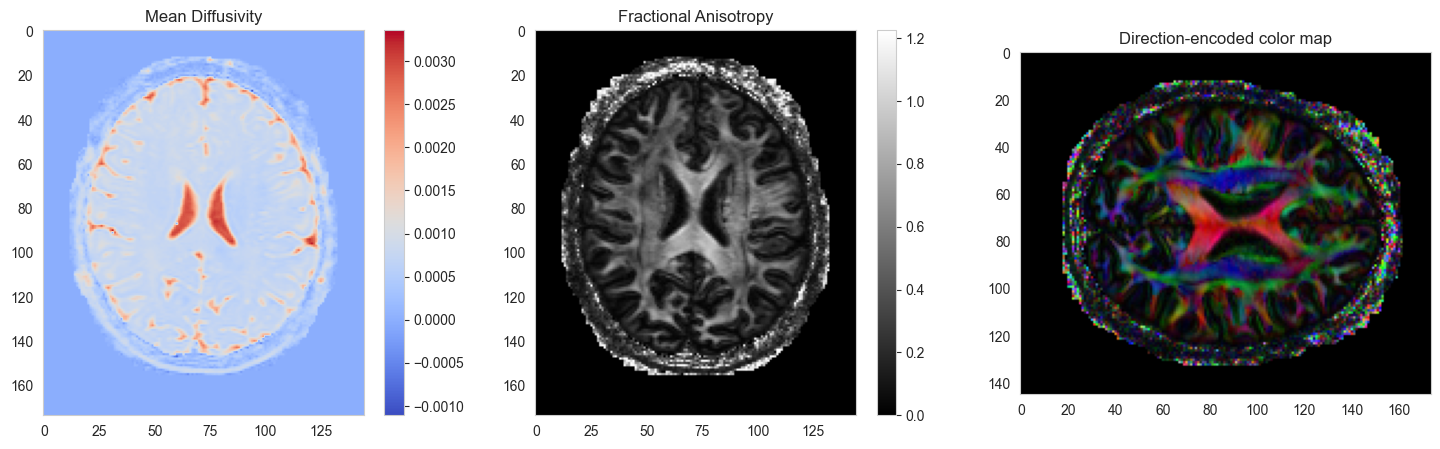

In [ ]:
slice_idx = 71
MD_map, FA_map, D  = create_parameter_maps(dwis, bvals, qhat, slice_idx)
RGB_map = create_RGB_map(dwis, bvals, qhat, slice_idx)

plt.figure(figsize=(18,5))
plt.subplot(131)
plt.imshow(np.flipud(MD_map.T), cmap='coolwarm')
plt.title('Mean Diffusivity')
plt.colorbar()

plt.subplot(132)
plt.imshow(np.flipud(FA_map.T), cmap='gray')
plt.title('Fractional Anisotropy')
plt.colorbar()

plt.subplot(133)
plt.imshow(np.flipud(RGB_map))
plt.title('Direction-encoded color map')

plt.show()

$\Large{Q1.1.2}$

In [ ]:
def ball_stick(x, bvals, qhat):
    # Behrens et al, 2003
    # Characterization and Propagation of Uncertainty in Diffusion-Weighted MR Imaging
    # https://doi.org/10.1002/mrm.10609
    
    # Extract the parameters
    # diff: diffusion
    # f: fraction of signal contributed by diffusion tensor along fiber direction theta, phi
    S0, diff, f, theta, phi = x
    
    # Fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    tile = np.tile(fibdir, (len(bvals), 1))
    fibdotgrad = np.sum(qhat * tile, axis=1)
    
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
    return S

def BallStickSSD(x, voxel, bvals, qhat):
    S = ball_stick(x, bvals, qhat)
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)

In [ ]:
# from scipy.optimize.optimize import fminunc  # Note: Python uses scipy.optimize.minimize instead
from scipy.optimize import minimize

# Get data from single voxel (as mentioned in coursework)
voxel = dwis[:,91,64,71]

# Starting point (as given in coursework)
startx = np.array([3500, -5e-6, 120, 0, 0])

# Define optimization options
options = {
    'maxiter': 20000,
    'ftol': 1e-10,
    'gtol': 1e-10,
}

# Run optimization
result = minimize(BallStickSSD, startx, args=(voxel, bvals, qhat), 
                 method='Nelder-Mead', options=options)

#print(result)
# Get fitted parameters
parameter_hat = result.x
residual_norm = result.fun

print("Fitted parameters:")
print(f"S0: {parameter_hat[0]:.4e}")
print(f"diff: {parameter_hat[1]:.4e}")
print(f"f: {parameter_hat[2]:.4e}")
print(f"theta: {parameter_hat[3]:.4e}")
print(f"phi: {parameter_hat[4]:.4e}")
print(f"\nResidual norm: {residual_norm:.4e}")

Fitted parameters:
S0: 3.2604e+03
diff: -1.1048e-06
f: 4.5670e+02
theta: 7.1847e-02
phi: 1.6297e+00

Residual norm: 5.4699e+07


C:\Users\Gugu\AppData\Local\Temp\ipykernel_151084\2909648936.py:18: OptimizeWarning: Unknown solver options: ftol, gtol
  result = minimize(BallStickSSD, startx, args=(voxel, bvals, qhat),


In [ ]:
# Generate model predictions
S_predicted = ball_stick(parameter_hat, bvals, qhat)

plot_model_fit(voxel, S_predicted, "BallStickSSD", marker_size=6)

$\Large{Q1.1.3}$

$\text{Transform parameters to be realistic values}$

In [ ]:
def transform_parameters(x_transformed):
    """Transform parameters to enforce constraints"""
    S0 = x_transformed[0]**2  # Positive
    diff = x_transformed[1]**2  # Positive
    
    # Safer sigmoid implementation with clipping to avoid numerical issues
    f_transform = np.clip(x_transformed[2], -100, 100)  # Prevent overflow
    f = 1/(1 + np.exp(-f_transform))
    
    theta = x_transformed[3]
    phi = x_transformed[4]
    
    params = np.array([S0, diff, f, theta, phi])
    # print(f"Transformed parameters: {params}")  # Debug print
    return params

def ball_stick_constrained(x_transformed, bvals, qhat):
    """Takes unconstrained parameters and transforms them. Passes the transformed parameters 
    to the ball and stick model. Returns predicted signals from ball and stick."""
    # Transform parameters to enforce constraints
    x = transform_parameters(x_transformed)
    
    # Use original ball_stick with transformed parameters
    return ball_stick(x, bvals, qhat)

def BallStickSSD_constrained(x_transformed, voxel, bvals, qhat):
    """Calculates the sum of squared differences between the measured and predicted signals. Returnings the sum of errors."""
    S = ball_stick_constrained(x_transformed, bvals, qhat)
    return np.sum((voxel - S) ** 2)

In [ ]:

# Need to transform starting point to match constrained parameters
# If startx was [3500, -5e-6, 120, 0, 0]
# We need to invert the transformations:
# startx = np.array([3500, -5e-6, 120, 0, 0]) 

startx_transformed = np.array([
    np.sqrt(3500),          # sqrt for S0
    np.sqrt(5e-6),         # sqrt for diff (use positive value)
    0,                     # logit for f (start with f=0.5)
    0,                     # theta unchanged
    0                      # phi unchanged
])

bounds = [
    (-np.inf, np.inf),  # S0
    (-np.inf, np.inf),  # diff
    (-20, 20),         # f (sigmoid will map to ~0 to ~1)
    (-np.pi, np.pi),   # theta
    (-np.pi, np.pi)    # phi
]


# Run optimization with constrained version
result = minimize(BallStickSSD_constrained, 
                 startx_transformed, 
                 args=(voxel, bvals, qhat),
                 bounds=bounds,                 
                 method='L-BFGS-B',
                 options={'maxiter': 20000, 'ftol': 1e-10})


# Generate model predictions
# Get fitted parameters (need to transform back)
parameter_hat = transform_parameters(result.x)
residual_norm = result.fun
S_predicted = ball_stick(parameter_hat, bvals, qhat)


print("Fitted parameters (constrained):")
print(f"S0: {parameter_hat[0]:.4e}")
print(f"diff: {parameter_hat[1]:.4e}")
print(f"f: {parameter_hat[2]:.4e}")
print(f"theta: {parameter_hat[3]:.4e}")
print(f"phi: {parameter_hat[4]:.4e}")
print(f"\nResidual norm: {residual_norm:.4e}")

plot_model_fit(voxel, S_predicted, "BallStickSSD", marker_size=6)

Fitted parameters (constrained):
S0: 4.2579e+03
diff: 1.1413e-03
f: 3.5731e-01
theta: -9.8107e-01
phi: 5.7945e-01

Residual norm: 5.8720e+06


TODO: MAYBE plot lines for the measured vs predicited b values.

$\text{Our residuals have decreased by a factor of 10, which is good. Now all our parameters are in the correct range and sign.}$

$\Large{Q1.1.4}$

$\text{Add random starting points based on a normal distribution of our original start parameters. Use a fitting loop to see which parameters.}$

In [ ]:
"""CREATE normally distributed random starts around our original start_x (S0=3500, etc...) """
def generate_random_starts(n_trials, base_params):
    """Generate random starting points around base parameters
    
    Args:
        n_trials: Number of random starting points to generate
        base_params: Base parameters [S0, diff, f, theta, phi]
    """
    # Set standard deviations as percentage of base values or fixed values
    stds = [
        0.1 * base_params[0],  # 10% of S0
        0.1 * base_params[1],  # 10% of diff
        0.1,                   # Fixed std for f
        np.pi/8,              # Fixed std for theta
        np.pi/8               # Fixed std for phi
    ]

    # Generate random starts
    random_starts = np.zeros((n_trials, 5))
    for i in range(5):
        random_starts[:,i] = np.random.normal(
            loc=base_params[i], 
            scale=stds[i], 
            size=n_trials
        )
    
    return random_starts

Success rate of finding global minimum: 80.0%

Best fit parameters:
S0: 4.2579e+03
diff: 1.1413e-03
f: 3.5731e-01
theta: -9.8107e-01
phi: 5.7945e-01
Residual norm: 5.8720e+06


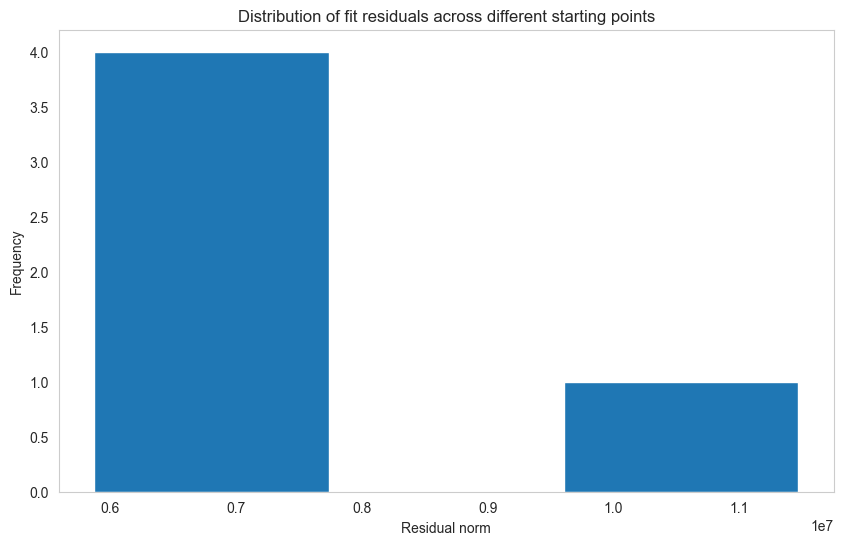

In [ ]:
def generate_starting_points(n_trials, base_point):
    """
    Generate n_trials starting points by adding Gaussian noise to base_point.
    Scale of noise should reflect scale of each parameter.
    """
    # Define standard deviations for each parameter that reflect their scales
    scales = np.array([
        np.sqrt(3500) * 0.1,    # S0: 10% of sqrt(base S0)
        np.sqrt(5e-6) * 0.1,    # diff: 10% of sqrt(base diff)
        1.0,                     # f transform: scale of ~1 for logit space
        np.pi/4,                # theta: quarter turn in radians
        np.pi/4                 # phi: quarter turn in radians
    ])
    
    # Generate starting points
    starting_points = np.zeros((n_trials, 5))
    for i in range(n_trials):
        noise = np.random.normal(0, 1, 5) * scales
        starting_points[i] = base_point + noise
    
    return starting_points

def fit_multiple_starts(voxel, bvals, qhat, model_to_fit,  n_trials=5):
    """
    Fit ball-stick model multiple times with different starting points.
    Returns all results and identifies how often we find the global minimum.
    """
    # Base starting point (transformed space)
    base_start = np.array([
        np.sqrt(3500),      # S0
        np.sqrt(5e-6),      # diff
        0,                  # f (transforms to 0.5) 
        0,                  # theta
        0                   # phi
    ])
    
    # Generate starting points
    starting_points = generate_starting_points(n_trials, base_start)
    
    # Store results
    all_results = []
    all_resnorms = []
    
    # Fit from each starting point
    for i in range(n_trials):
        result = minimize(model_to_fit, 
                        starting_points[i], 
                        args=(voxel, bvals, qhat),
                        method='L-BFGS-B',
                        bounds=bounds,
                        options={'maxiter': 20000, 'ftol': 1e-10})
        
        all_results.append(result)
        all_resnorms.append(result.fun)
    
    # Find best result and count how often we find it
    best_resnorm = np.min(all_resnorms)
    tolerance = 1  # Define what we consider "same" minimum
    n_global = np.sum(np.abs(all_resnorms - best_resnorm) < tolerance)
    
    # Get best result
    best_idx = np.argmin(all_resnorms)
    best_result = all_results[best_idx]
    
    return best_result, n_global/n_trials, all_results

# Run the multiple start fitting
best_fit, success_rate, all_fits = fit_multiple_starts(voxel, bvals, qhat, BallStickSSD_constrained)

# Print results
print(f"Success rate of finding global minimum: {success_rate*100:.1f}%")
print("\nBest fit parameters:")
best_params = transform_parameters(best_fit.x)
print(f"S0: {best_params[0]:.4e}")
print(f"diff: {best_params[1]:.4e}")
print(f"f: {best_params[2]:.4e}")
print(f"theta: {best_params[3]:.4e}")
print(f"phi: {best_params[4]:.4e}")
print(f"Residual norm: {best_fit.fun:.4e}")

# Visualize distribution of residual norms
plt.figure(figsize=(10,6))
plt.hist([fit.fun for fit in all_fits], bins=3)
plt.xlabel('Residual norm')
plt.ylabel('Frequency')
plt.title('Distribution of fit residuals across different starting points')
plt.show()

In [ ]:
p = 0.75
n = np.log(0.05)/np.log(1-p)
print(f"Trials needed for 95% confidence: {np.ceil(n)}")

Trials needed for 95% confidence: 3.0


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
voxel_indices = [
    (91, 64, 71),  # Original voxel
    (93, 63, 71),  # Second voxel
    (89, 34, 71),  # Third voxel 
    (60, 65, 71)   # Fourth voxel
]

for voxel_index in voxel_indices:
    i, j, k = voxel_index  # Get indices for first voxel
    voxel = dwis[:, i, j, k]
    best_fit, success_rate, all_fits = fit_multiple_starts(voxel, bvals, qhat, BallStickSSD_constrained, n_trials=100)

    # Extract residual norms
    residual_norms = [fit.fun for fit in all_fits]
    
    p = success_rate
    n = np.log(0.05)/np.log(1-p)

    # Create figure with two subplots
    stats_text = (
        f'VOXEL: [:,{i},{j},{k}]\n'        
        f'Number of trials: {len(residual_norms)}\n'
        f'Minimum RESNORM: {min(residual_norms):.2e}\n'
        f'Mean RESNORM: {np.mean(residual_norms):.2e}\n'
        f'Success rate: {success_rate*100:.1f}%\n'
        f'Number of solutions within 0.1% of minimum: '
        f'{sum(norm <= min(residual_norms)*1.001 for norm in residual_norms)} \n'
        f'Trials needed for 95% confidence: {np.ceil(n)}\n'
    )

    print(stats_text)

VOXEL: [:,91,64,71]
Number of trials: 100
Minimum RESNORM: 5.87e+06
Mean RESNORM: 8.21e+06
Success rate: 74.0%
Number of solutions within 0.1% of minimum: 74 
Trials needed for 95% confidence: 3.0

VOXEL: [:,93,63,71]
Number of trials: 100
Minimum RESNORM: 5.69e+06
Mean RESNORM: 8.67e+06
Success rate: 75.0%
Number of solutions within 0.1% of minimum: 75 
Trials needed for 95% confidence: 3.0

VOXEL: [:,89,34,71]
Number of trials: 100
Minimum RESNORM: 7.96e+06
Mean RESNORM: 9.23e+06
Success rate: 51.0%
Number of solutions within 0.1% of minimum: 52 
Trials needed for 95% confidence: 5.0

VOXEL: [:,60,65,71]
Number of trials: 100
Minimum RESNORM: 4.61e+06
Mean RESNORM: 1.09e+07
Success rate: 75.0%
Number of solutions within 0.1% of minimum: 76 
Trials needed for 95% confidence: 3.0



$\text{Calculate the number of trials requried to be 95\% sure}$

$$0.25^{n} = 0.05$$
$$log(0.25^{n}) = log(0.05)$$
$$n = log(0.05) / log(0.25)$$

$$n = 4.75 $$

After 100 trials, we find that ~78% of the RESNORMs are in the 6e6 bin. We need a minimum of 5 trials to be 95% confident that we have found a global minimum. I have exceeded that with 100 trials.  

$\Large{Q1.1.5}$

<h2>Create parameters maps over slice 72

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import minimize
from joblib import Parallel, delayed
from tqdm import tqdm
import math

def ball_stick(x, bvals, qhat):
    S0 = x[0] ** 2  # Ensure S0 > 0
    diff = x[1] ** 2  # Ensure diff > 0
    f_transform = np.clip(x[2], -100, 100)  # Prevent overflow
    f = 1/(1 + np.exp(-f_transform))    
    # f = 1 / (1 + np.exp(-x[2]))  # Maps f to [0,1]
    theta = np.pi * (1 / (1 + np.exp(-x[3])))  # Maps theta to [0, π]
    phi = 2 * np.pi * (1 / (1 + np.exp(-x[4])))  # Maps phi to [0, 2π]

    # Fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    # Make sure qhat is properly shaped for dot product
    # qhat_reshaped = qhat.T if qhat.shape[0] == 3 else qhat
    # fibdotgrad = np.einsum('ij,j->i', qhat_reshaped, fibdir)
    fibdotgrad = np.einsum('ij,ij->i', qhat, np.tile(fibdir, (len(bvals), 1)))
    
    # fibdotgrad = np.einsum('ij,ij->i', qhat.T, np.tile(fibdir, (len(bvals), 1)))

    # Signal model
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1 - f) * np.exp(-bvals * diff))
    return S

def BallStickSSD(x, voxel, bvals, qhat):
    S = ball_stick(x, bvals, qhat)
    return np.sum((voxel - S) ** 2)

def optimize_voxel(i, j, dwi, slice_idx, bvals, qhat, num_restarts=1, tol=1e-10):
    """
    Optimizes a single voxel and returns its parameters, residual norm, and percentage minima.
    """
    voxel = dwi[:,i,j,slice_idx]
    if np.min(voxel) <= 0:  # Skip if voxel has non-positive values
        return i, j, None, None, None

    best_residual = np.inf
    best_parameters = None
    resnorm_list = []

    for _ in range(num_restarts):
        startx = np.array([
        # np.sqrt(3500),      # S0
        # np.sqrt(5e-6),      # diff            
            np.sqrt(np.random.uniform(500, 4000)),  # Random S0
            np.sqrt(np.random.uniform(0.0005, 0.002)),  # Random diff
            # 0,
            # 0,
            # 0
            np.random.uniform(-1, 1),  # f
            np.random.uniform(-2, 2),  # theta
            np.random.uniform(-2, 2)   # phi
        ])
        
        bounds = [
            (-np.inf, np.inf),  # S0
            (-np.inf, 0.006),  # diff
            (-20, 20),         # f (sigmoid will map to ~0 to ~1)
            (-np.pi, np.pi),   # theta
            (-np.pi, np.pi)    # phi
        ]
        
        options = {
            'maxiter': 20000,
            'ftol': 1e-8,      # Looser tolerance
            'eps': 1e-8,       # Adjust gradient approximation step
            'maxfun': 20000    # Allow more function evaluations
        }
        # result_nm = minimize(BallStickSSD, startx, args=(voxel, bvals, qhat), method='Nelder-Mead', options={'maxiter':1000})
        # result = minimize(BallStickSSD, result_nm.x, args=(voxel, bvals, qhat),  method='L-BFGS-B', options=options)

        result = minimize(BallStickSSD, startx, args=(voxel, bvals, qhat),
                        method='L-BFGS-B',
                        # method='Nelder-Mead',
                        options = {
                            'maxiter': 1000,
                            # 'xatol': 1e-8,
                            # 'fatol': 1e-10
                        },
                        bounds=bounds
                        )

        resnorm_list.append(result.fun)

        if result.fun < best_residual:
            best_residual = result.fun
            best_parameters = result.x

    global_minima = np.min(resnorm_list)
    count_minima = np.count_nonzero(np.isclose(resnorm_list, global_minima, atol=tol))

    return i, j, best_parameters, global_minima, count_minima / num_restarts
    

def optimize_slice(dwi, bvals, qhat, slice_idx, num_restarts=1):
    """
    Runs constrained optimization over a full slice using parallel processing.
    """
    Dx, Dy = dwi.shape[1:3]
    
    # Create list of voxel coordinates to process
    coords = [(i, j) for i in range(Dx) for j in range(Dy)]
    
    # Run parallel optimization
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(optimize_voxel)(i, j, dwi, slice_idx, bvals, qhat, num_restarts)
        for i, j in tqdm(coords)
    )

    # Initialize storage arrays
    param_maps = np.zeros((5, Dx, Dy))  # Stores S0, d, f, theta, phi
    resnorm_map = np.zeros((Dx, Dy))
    perc_min_map = np.zeros((Dx, Dy))

    # Store results
    for i, j, params, global_minima, count_minima in results:
        if params is not None:
            param_maps[:, i, j] = params
            resnorm_map[i, j] = global_minima
            perc_min_map[i, j] = count_minima

    return param_maps, resnorm_map, perc_min_map

# Function to run the full analysis
def run_analysis(dwis, bvals, qhat, slice_idx=71, num_restarts=1):
    # Run optimization
    # print(f"Optimizing slice {slice_idx}...")
    param_maps, resnorm_map, perc_min_map = optimize_slice(dwis, bvals, qhat, slice_idx, num_restarts)

    # Transform parameters back to original scale
    S0_map = param_maps[0] ** 2
    d_map = param_maps[1] ** 2
    f_map = 1 / (1 + np.exp(-param_maps[2]))
    theta_map = np.pi * (1 / (1 + np.exp(-param_maps[3])))
    phi_map = 2 * np.pi * (1 / (1 + np.exp(-param_maps[4])))

    return S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map

# Usage example:
# Load your data
# data = scipy.io.loadmat('data_p1/data.mat')
# dwis = np.double(data['dwis'])
# qhat = np.loadtxt("data_p1/bvecs", delimiter=" ").T
# bvals = 1000 * np.sum(qhat * qhat, axis=1)

# Run analysis
maps = run_analysis(dwis, bvals, qhat, slice_idx=71, num_restarts=1)
S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map = maps

# Plot results
# plot_parameter_maps(S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map)


def plot_fiber_directions(n_x, n_y, f_map, d_map, threshold=1e-4):
    """
    Plot fiber directions with masking for areas outside the brain
    
    Parameters:
    -----------
    n_x, n_y : 2D arrays
        x and y components of the fiber directions
    f_map : 2D array
        Volume fraction map
    d_map : 2D array
        Diffusivity map
    threshold : float
        Threshold value for masking - voxels with diffusivity below this are considered outside the brain
    """
    Dx, Dy = n_x.shape
    X, Y = np.meshgrid(np.arange(Dx), np.arange(Dy))
    
    # Create mask for brain tissue based on diffusivity
    brain_mask = d_map > threshold
    
    # Apply mask to directional components and coordinates
    mask_indices = np.where(brain_mask.T)  # Transpose to match quiver coordinates
    X_masked = X[mask_indices]
    Y_masked = Y[mask_indices]
    U_masked = n_x.T[mask_indices]
    V_masked = n_y.T[mask_indices]
    
    
    skip=5
    # Downsample everything
    X_masked = X_masked[::skip]
    Y_masked = Y_masked[::skip]
    U_masked = U_masked[::skip]
    V_masked = V_masked[::skip]
    # Create figure
    plt.figure(figsize=(12, 12))
    
    # Plot background volume fraction map
    plt.imshow(f_map.T, cmap='gray', origin='lower', alpha=0.9)
    
    # Plot quiver only for brain voxels
    plt.quiver(X_masked, Y_masked, U_masked, V_masked, 
              angles='xy', scale_units='xy', scale=0.05, 
              headwidth=5, color="red", alpha=1)
    
    plt.title("Fiber Direction Map (Weighted by f)")
    plt.xlabel("Voxel X")
    plt.ylabel("Voxel Y")
    plt.gca().invert_yaxis()
    plt.show()

# Plot fiber directions
n_x = f_map * np.sin(theta_map) * np.cos(phi_map)
n_y = f_map * np.sin(theta_map) * np.sin(phi_map)
plot_fiber_directions(n_x, n_y, f_map, d_map)
# """

 24%|██▍       | 6160/25230 [00:05<00:09, 2039.56it/s]

: 

In [ ]:
# For a numpy array 'arr':
print(f"""
Count: {len(d_map)}
Mean: {np.mean(d_map)}
Std: {np.std(d_map)}
Min: {np.min(d_map)}
25%: {np.percentile(d_map, 25)}
Median: {np.median(d_map)}
75%: {np.percentile(d_map, 75)}
Max: {np.max(d_map)}
""")


Count: 145
Mean: 0.0005460036778809222
Std: 0.0006911034256809975
Min: 0.0
25%: 0.0
Median: 0.00044636106558439083
75%: 0.0009575251773091442
Max: 0.05559373754082566



In [ ]:
d_map = np.where(d_map > 0.006, 0, d_map)  # 0.003 is typical max diffusivity


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_parameter_maps(S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map, figsize=(20, 15)):

    # Set the style
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Create figure and subplots
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    fig.suptitle('Ball and Stick Model Parameter Maps', fontsize=16, y=1.02)
    
    # Flatten axes for easier iteration
    axes = axes.ravel()
    
    # Create maps list with titles and data
    maps = [
        ('S0 Map', S0_map, 'viridis'),
        ('Diffusivity Map', d_map, 'viridis'),
        ('Volume Fraction Map', f_map, 'RdYlBu_r'),
        ('Residual Norm Map', np.log10(resnorm_map), 'coolwarm'),
        ('Global Minima %', perc_min_map, 'YlOrRd'),
        ('Theta Map', theta_map, 'magma'),
        ('Phi Map', phi_map, 'magma'),
    ]
    
    # Plot each map
    for idx, (title, data, cmap) in enumerate(maps):
        if idx < len(axes):  # Ensure we don't exceed available axes
            ax = axes[idx]
            
            # Create heatmap
            im = ax.imshow(np.flipud(data.T), cmap=cmap)
            
            # Add colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            
            # Set title and remove ticks
            ax.set_title(title, pad=10, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Remove empty subplot
    axes[-1].remove()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    return fig

C:\Users\Gugu\AppData\Local\Temp\ipykernel_151084\3348152189.py:22: RuntimeWarning:

divide by zero encountered in log10



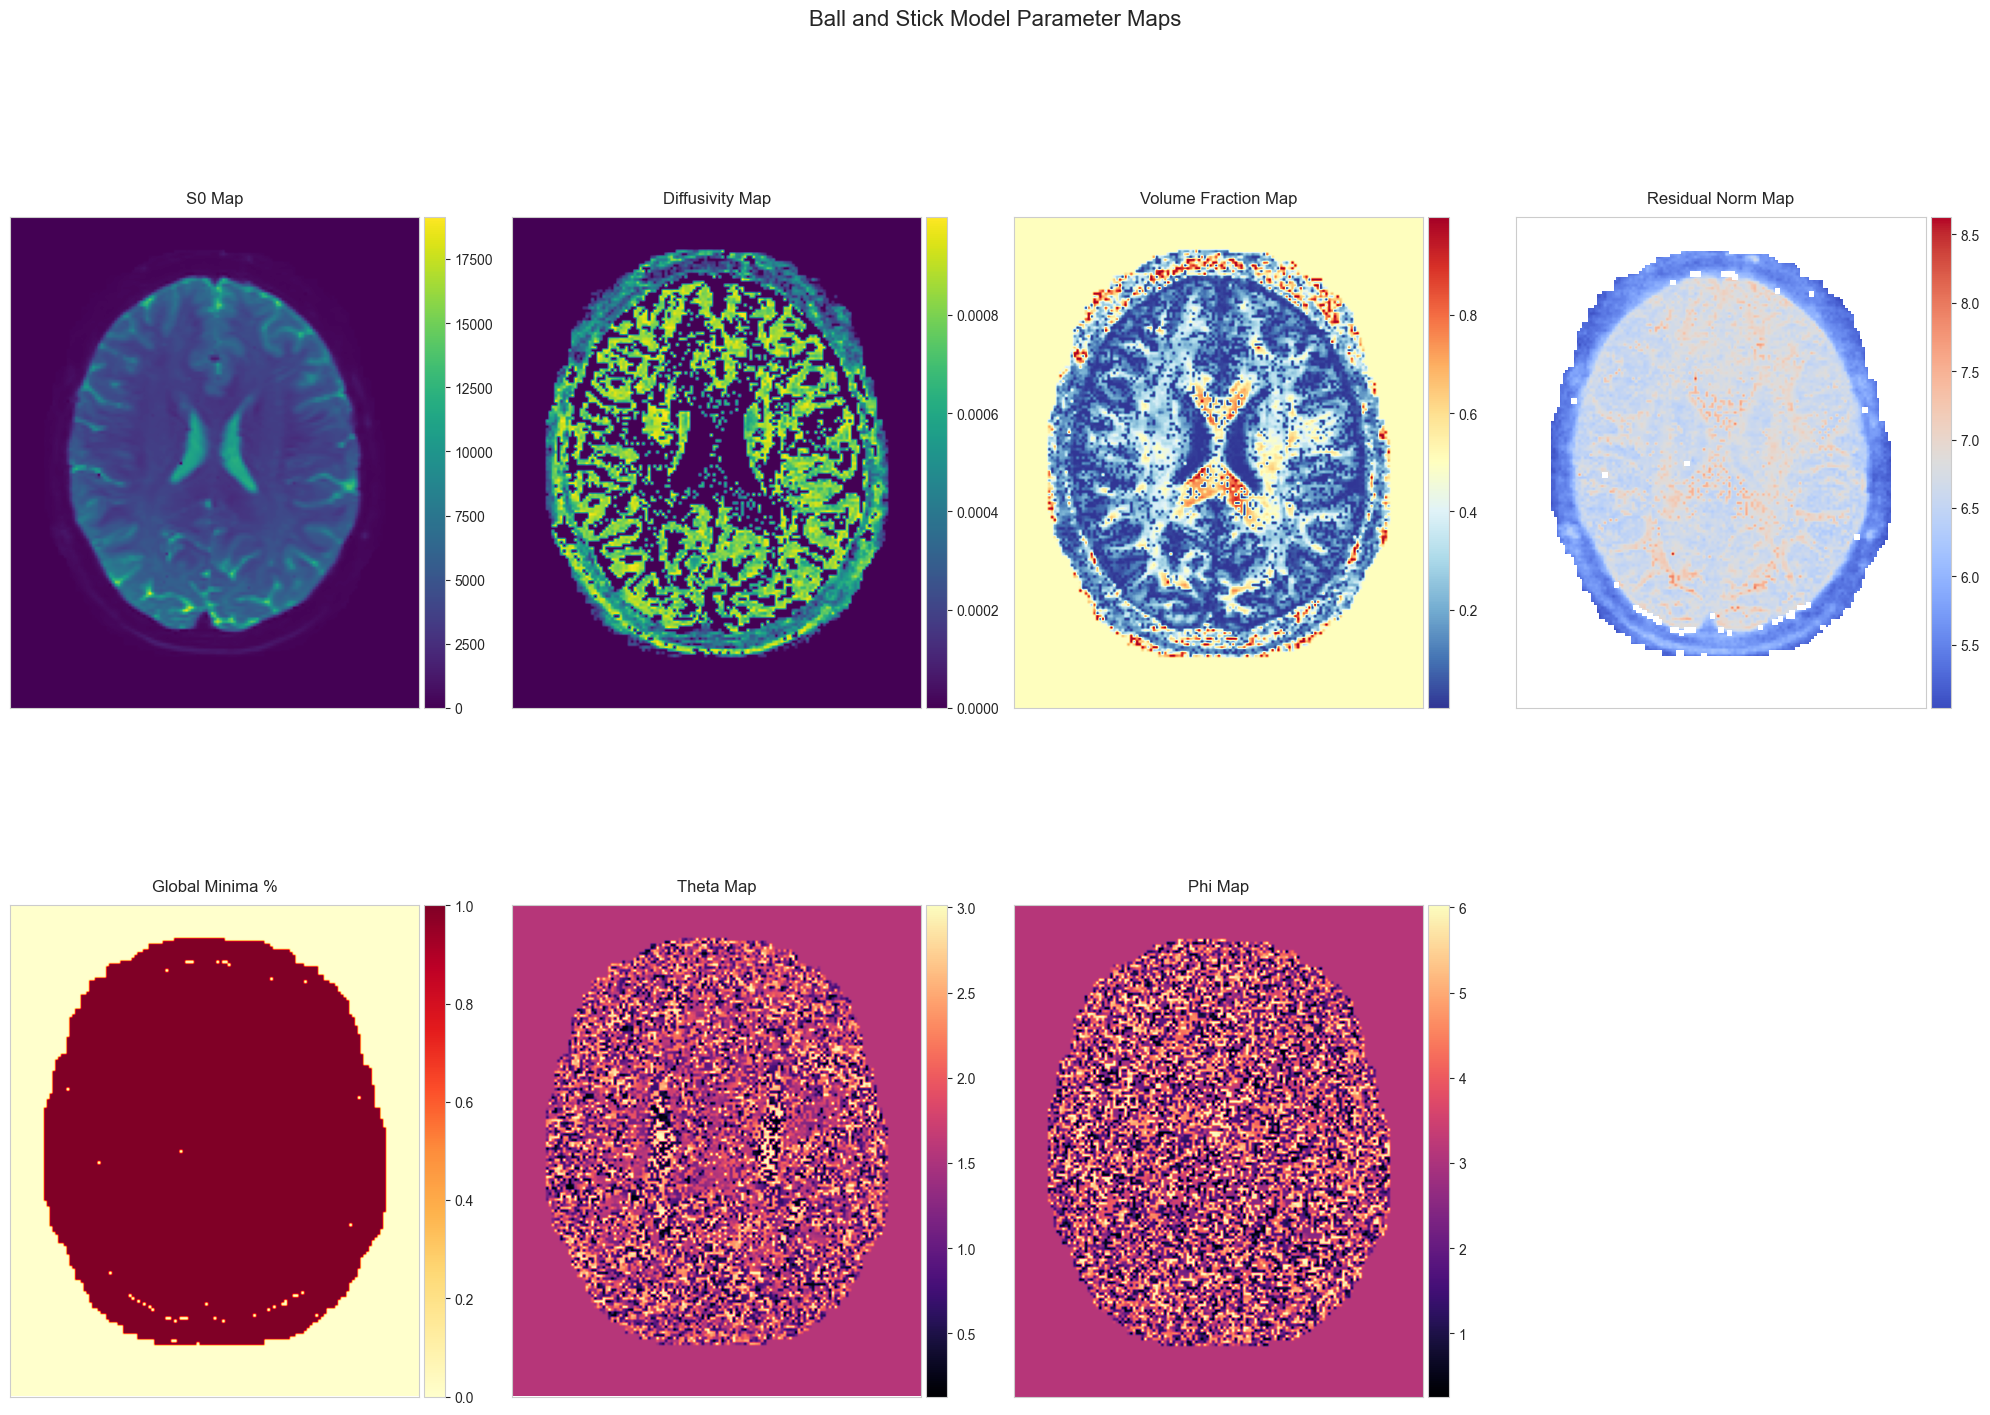

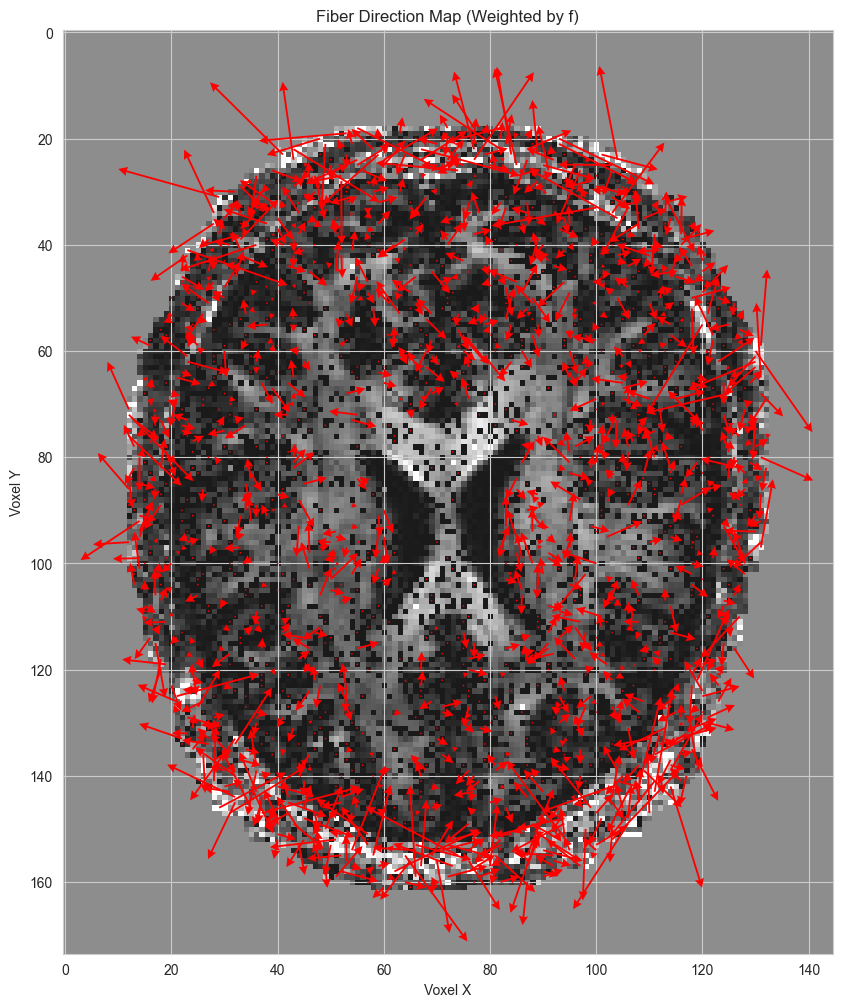

In [ ]:
# S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map = maps
# Plot results
plot_parameter_maps(S0_map, d_map, f_map, resnorm_map, perc_min_map, theta_map, phi_map)
    
# Plot fiber directions
n_x = f_map * np.sin(theta_map) * np.cos(phi_map)
n_y = f_map * np.sin(theta_map) * np.sin(phi_map)
plot_fiber_directions(n_x, n_y, f_map, d_map)    

# Q1.2 - Uncertainty Estimation

$\Large{Q1.2.1}$

In [ ]:
def bootstrap_ballstick(voxel, bvals, qhat, n_bootstraps=1000):
    """
    Perform bootstrap estimation of ball-and-stick parameters
    Returns parameter distributions and confidence intervals
    """
    n_measurements = len(voxel)
    # Store bootstrap parameter estimates
    bootstrap_params = np.zeros((n_bootstraps, 5))
    
    # Get initial fit to use as starting point
    base_start = np.array([
        np.sqrt(3500),      # S0
        np.sqrt(5e-6),      # diff
        0,                  # f (transforms to 0.5)
        0,                  # theta
        0                   # phi
    ])
    
    bounds = [
        (-np.inf, np.inf),  # S0
        (-np.inf, np.inf),  # diff
        (-20, 20),         # f 
        (-np.pi, np.pi),   # theta
        (-np.pi, np.pi)    # phi
    ]
    
    # Perform bootstrap iterations
    for i in range(n_bootstraps):
        # Generate bootstrap sample by random resampling with replacement
        indices = np.random.randint(0, n_measurements, n_measurements)
        bootstrap_sample = voxel[indices]
        bootstrap_bvals = bvals[indices]
        bootstrap_qhat = qhat[indices]
        
        # Fit model to bootstrap sample
        result = minimize(BallStickSSD_constrained, 
        # result = minimize(BallStickSSD, 
                        base_start,
                        args=(bootstrap_sample, bootstrap_bvals, bootstrap_qhat),
                        method='L-BFGS-B',
                        bounds=bounds,
                        options={'maxiter': 20000, 'ftol': 1e-10})
        
        # Store transformed parameters
        bootstrap_params[i] = transform_parameters(result.x)
        
    # Calculate confidence intervals
    
    #TODO: Calculate range from 
    two_sigma = np.percentile(bootstrap_params, [2.5, 97.5], axis=0)  # 95% CI (2-sigma)
    ninety_five = np.percentile(bootstrap_params, [2.5, 97.5], axis=0)  # 95% range
    
    return bootstrap_params, two_sigma, ninety_five

# Run bootstrap analysis for our test voxel
voxel = dwis[:,91,64,71]
bootstrap_params, two_sigma, ninety_five = bootstrap_ballstick(voxel, bvals, qhat)

# Print results
param_names = ['S0', 'd', 'f', 'theta', 'phi']
print("\n95% ranges:")
for i, name in enumerate(param_names):
    print(f"{name}: [{ninety_five[0,i]:.3e}, {ninety_five[1,i]:.3e}]")

print("2-sigma ranges (95% confidence intervals):")
for i, name in enumerate(param_names):
    print(f"{name}: [{two_sigma[0,i]:.3e}, {two_sigma[1,i]:.3e}]")


# Let's also visualize the distributions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, name in enumerate(param_names):
    axs[i].hist(bootstrap_params[:,i], bins=50)
    axs[i].set_title(f'{name} distribution')
    axs[i].axvline(two_sigma[0,i], color='r', linestyle='--')
    axs[i].axvline(two_sigma[1,i], color='r', linestyle='--')

plt.tight_layout()
plt.show()

# # Let's try some other voxels for comparison
# test_voxels = [
#     (91,64,71),  # Original voxel
#     (92,65,71),  # Adjacent voxel
#     (100,80,71)  # Different region
# ]

# results = []
# for coords in test_voxels:
#     voxel = dwis[:,coords[0],coords[1],coords[2]]
#     if np.all(voxel > 0):  # Check if voxel has valid data
#         bootstrap_params, two_sigma, _ = bootstrap_ballstick(voxel, bvals, qhat, n_bootstraps=500)
#         results.append((coords, two_sigma))

# # Compare results across voxels
# print("\nComparing 2-sigma ranges across voxels:")
# for (coords, two_sigma) in results:
#     print(f"\nVoxel at {coords}:")
#     for i, name in enumerate(param_names):
#         print(f"{name}: [{two_sigma[0,i]:.3e}, {two_sigma[1,i]:.3e}]")

$\Large{Q1.2.2}$

MCMC acceptance rate: 0.24


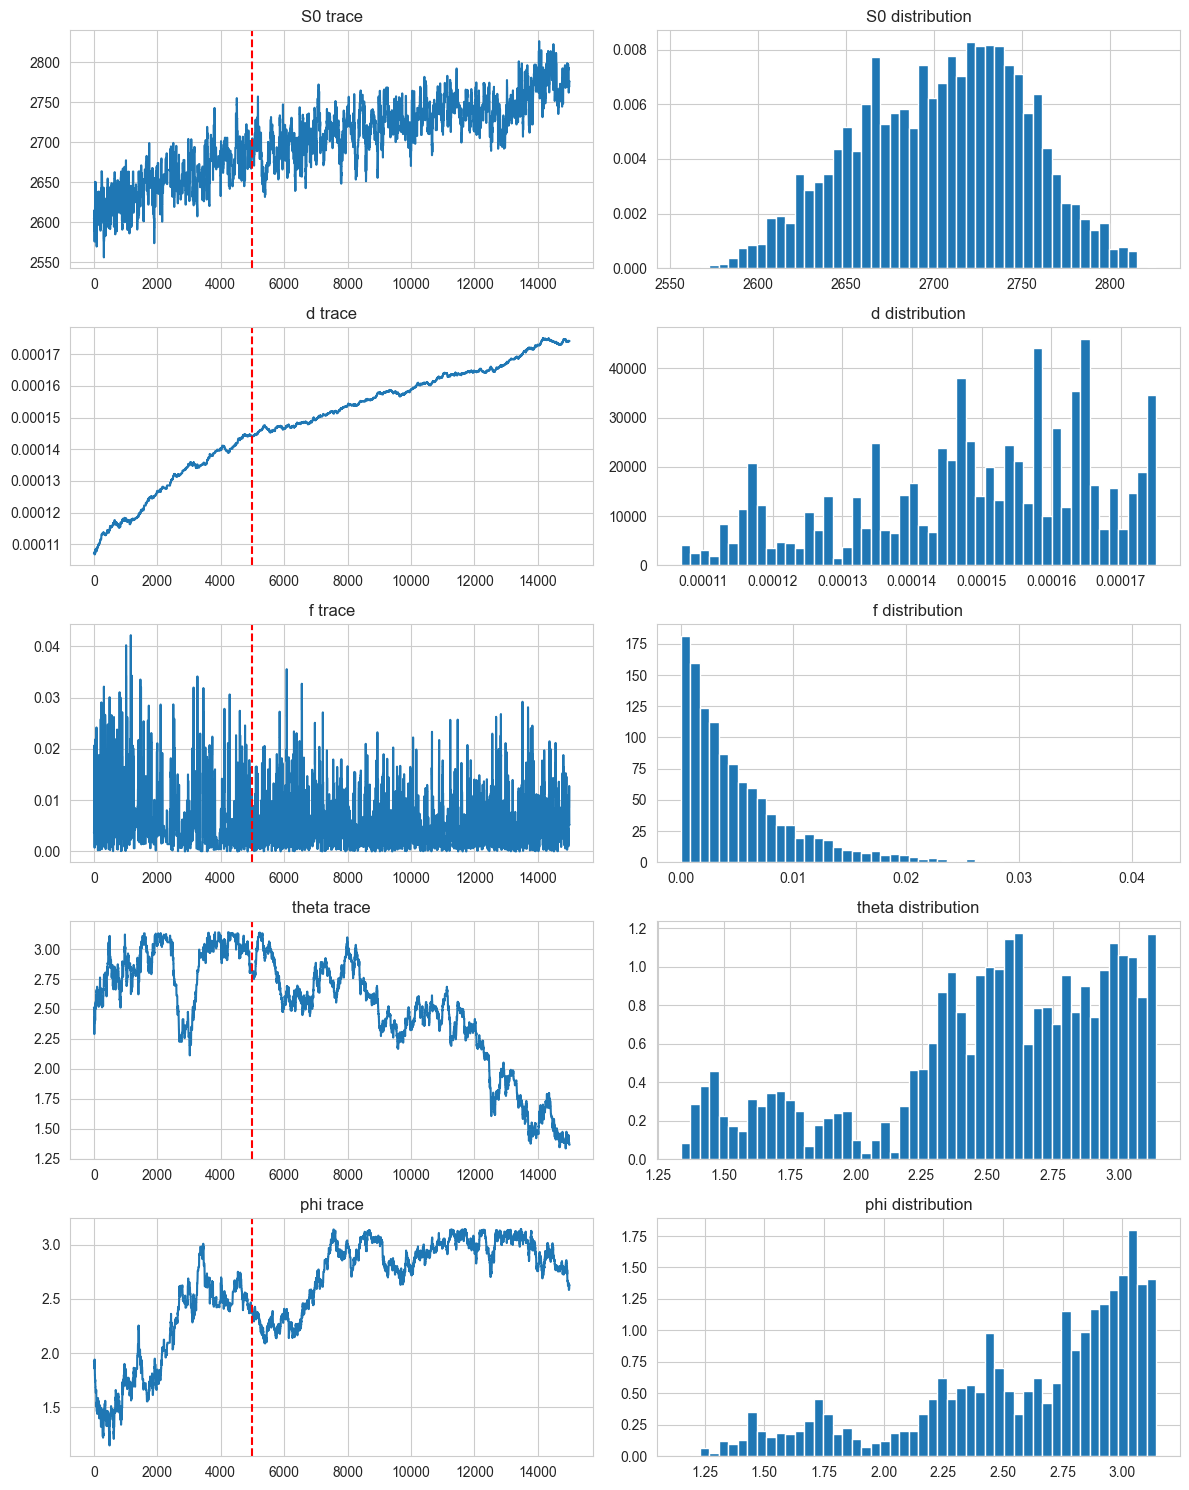


MCMC Parameter Estimates (2-sigma ranges):
S0: [2.610e+03, 2.791e+03]
d: [1.135e-04, 1.743e-04]
f: [8.189e-05, 1.935e-02]
theta: [1.442e+00, 3.119e+00]
phi: [1.448e+00, 3.124e+00]


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def log_likelihood(params, voxel, bvals, qhat, noise_std=200):
    """
    Calculate log likelihood assuming Gaussian noise
    
    Args:
        params: Model parameters [S0, d, f, theta, phi]
        voxel: Observed diffusion signals
        bvals: b-values
        qhat: Gradient directions
        noise_std: Standard deviation of noise (default 200 as per coursework)
    """
    try:
        # Generate model predictions
        S0, d, f, theta, phi = params
        
        # Compute fiber direction
        fibdir = np.array([
            np.cos(phi) * np.sin(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(theta)
        ])
        
        # Compute dot product with gradient directions
        fibdotgrad = np.sum(qhat * np.tile(fibdir, (len(bvals), 1)), axis=1)
        
        # Generate predictions
        S = S0 * (f * np.exp(-bvals * d * (fibdotgrad**2)) + 
                  (1-f) * np.exp(-bvals * d))
        
        # Return log likelihood
        return -np.sum((voxel - S)**2) / (2 * noise_std**2)
    
    except:
        return -np.inf

def log_prior(params):
    """
    Calculate log prior probability - uniform within constraints
    
    Args:
        params: Model parameters [S0, d, f, theta, phi]
    """
    S0, d, f, theta, phi = params
    
    # Check constraints
    if (S0 <= 0 or        # S0 must be positive
        d <= 0 or         # diffusivity must be positive
        f < 0 or f > 1 or # volume fraction between 0 and 1
        theta < 0 or theta > np.pi or  # theta between 0 and pi
        phi < -np.pi or phi > np.pi):  # phi between -pi and pi
        return -np.inf
    
    return 0  # Uniform prior within constraints

def log_posterior(params, voxel, bvals, qhat):
    """Calculate log posterior probability"""
    log_pri = log_prior(params)
    if log_pri == -np.inf:
        return -np.inf
    return log_pri + log_likelihood(params, voxel, bvals, qhat)

def metropolis_hastings(voxel, bvals, qhat, n_steps=20000, noise_std=200):
    """
    Metropolis-Hastings MCMC sampler for ball-and-stick model
    
    Args:
        voxel: Observed diffusion signals
        bvals: b-values
        qhat: Gradient directions
        n_steps: Number of MCMC steps
        noise_std: Standard deviation of noise
        
    Returns:
        chain: MCMC samples
        acceptance_rate: Fraction of proposals accepted
    """
    # Initialize chain with reasonable starting values
    #TODO: check these values
    current = np.array([3500, 5e-6, 0.5, np.pi/2, 0])
    
    # Define proposal distribution scales for each parameter
    proposal_scales = np.array([100, 1e-6, 0.1, 0.2, 0.2])
    
    # Storage for chain
    chain = np.zeros((n_steps, 5))
    
    # Run MCMC
    accepted = 0
    for i in range(n_steps):
        # Propose new state
        proposal = current + np.random.normal(0, 1, 5) * proposal_scales
        
        # Calculate log acceptance ratio
        log_ratio = (log_posterior(proposal, voxel, bvals, qhat) - 
                    log_posterior(current, voxel, bvals, qhat))
        
        # Accept/reject
        if np.log(np.random.random()) < log_ratio:
            current = proposal
            accepted += 1
        
        chain[i] = current
        
        # Adapt proposal scales during burn-in
        if i < n_steps//2 and i % 100 == 0:
            acceptance_rate = accepted / (i + 1)
            if acceptance_rate < 0.2:
                proposal_scales *= 0.9
            elif acceptance_rate > 0.5:
                proposal_scales *= 1.1
    
    return chain, accepted/n_steps

def analyze_mcmc_results(chain, burnin=5000):
    """
    Analyze MCMC results and compute confidence intervals
    
    Args:
        chain: MCMC samples
        burnin: Number of initial samples to discard
        
    Returns:
        two_sigma: 2-sigma intervals (95% confidence)
        ranges_95: 95% ranges
    """
    # Discard burn-in
    samples = chain[burnin:,:]
    
    # Calculate intervals
    two_sigma = np.percentile(samples, [2.5, 97.5], axis=0)
    ranges_95 = np.percentile(samples, [2.5, 97.5], axis=0)
    
    return two_sigma, ranges_95

def plot_mcmc_diagnostics(chain, burnin=5000):
    """
    Plot MCMC diagnostic plots
    
    Args:
        chain: MCMC samples
        burnin: Number of initial samples to discard
    """
    samples = chain[burnin:,:]
    param_names = ['S0', 'd', 'f', 'theta', 'phi']
    
    fig, axs = plt.subplots(5, 2, figsize=(12, 15))
    for i, name in enumerate(param_names):
        # Trace plot
        axs[i,0].plot(samples[:,i])
        axs[i,0].set_title(f'{name} trace')
        axs[i,0].axvline(burnin, color='r', linestyle='--')
        
        # Histogram
        axs[i,1].hist(samples[:,i], bins=50, density=True)
        axs[i,1].set_title(f'{name} distribution')
    
    plt.tight_layout()
    return fig

# Get data from test voxel
voxel = dwis[:,91,64,71]

# Run MCMC
chain, acceptance_rate = metropolis_hastings(voxel, bvals, qhat)
print(f"MCMC acceptance rate: {acceptance_rate:.2f}")

# Analyze results
two_sigma, ranges_95 = analyze_mcmc_results(chain)

# Plot diagnostics
plot_mcmc_diagnostics(chain)
plt.show()

# Print results
param_names = ['S0', 'd', 'f', 'theta', 'phi']
print("\nMCMC Parameter Estimates (2-sigma ranges):")
for i, name in enumerate(param_names):
    print(f"{name}: [{two_sigma[0,i]:.3e}, {two_sigma[1,i]:.3e}]")

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def log_likelihood(params, voxel, bvals, qhat, fixed_angles, noise_std=0.04):
    """
    Calculate log likelihood assuming Gaussian noise
    
    Args:
        params: Model parameters [S0, d, f]
        voxel: Observed diffusion signals
        bvals: b-values
        qhat: Gradient directions
        fixed_angles: (theta, phi) tuple fixed at ML estimates
        noise_std: Standard deviation of noise (0.04 as per coursework)
    """
    try:
        # Extract parameters
        S0, d, f = params
        theta, phi = fixed_angles
        
        # Compute fiber direction (fixed)
        fibdir = np.array([
            np.cos(phi) * np.sin(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(theta)
        ])
        
        # Compute dot product with gradient directions
        fibdotgrad = np.sum(qhat * fibdir.reshape(3, 1), axis=0)
        
        # Generate predictions
        S = S0 * (f * np.exp(-bvals * d * (fibdotgrad**2)) + 
                  (1-f) * np.exp(-bvals * d))
        
        # Return log likelihood
        return -np.sum((voxel - S)**2) / (2 * noise_std**2)
    
    except:
        return -np.inf

def log_prior(params):
    """
    Calculate log prior probability - uniform within constraints
    
    Args:
        params: Model parameters [S0, d, f]
    """
    S0, d, f = params
    
    # Check constraints
    if (S0 <= 0 or        # S0 must be positive
        d <= 0 or         # diffusivity must be positive
        f < 0 or f > 1):  # volume fraction between 0 and 1
        return -np.inf
    
    return 0  # Uniform prior within constraints

def log_posterior(params, voxel, bvals, qhat, fixed_angles):
    """Calculate log posterior probability"""
    log_pri = log_prior(params)
    if log_pri == -np.inf:
        return -np.inf
    return log_pri + log_likelihood(params, voxel, bvals, qhat, fixed_angles)

def metropolis_hastings(voxel, bvals, qhat, fixed_angles, n_steps=20000):
    """
    Metropolis-Hastings MCMC sampler for ball-and-stick model parameters
    
    Args:
        voxel: Observed diffusion signals
        bvals: b-values
        qhat: Gradient directions
        fixed_angles: (theta, phi) tuple fixed at ML estimates
        n_steps: Number of MCMC steps
    
    Returns:
        chain: MCMC samples
        acceptance_rate: Fraction of proposals accepted
    """
    # Initialize chain with reasonable starting values
    current = np.array([
        3500,          # sqrt for S0
        5e-6,         # sqrt for diff (use positive value)
        0,                     # logit for f (start with f=0.5)
    ])
    
    # current = np.array([1.0, 2e-3, 0.5])  # Starting at typical values
    
    # Define proposal distribution scales for each parameter
    proposal_scales = np.array([1000, 1e-4, 0.05])  # Smaller steps for more stable sampling
    
    # Storage for chain
    chain = np.zeros((n_steps, 5))
    
    # Run MCMC
    accepted = 0
    for i in range(n_steps):
        # Propose new state
        proposal = current + np.random.normal(0, 1, 3) * proposal_scales
        
        # Calculate log acceptance ratio
        log_ratio = (log_posterior(proposal, voxel, bvals, qhat, fixed_angles) - 
                    log_posterior(current, voxel, bvals, qhat, fixed_angles))
        
        # Accept/reject
        if np.log(np.random.random()) < log_ratio:
            current = proposal
            accepted += 1
        
        chain[i] = current
        
        # Adapt proposal scales during burn-in
        if i < n_steps//2 and i % 100 == 0:
            acceptance_rate = accepted / (i + 1)
            if acceptance_rate < 0.2:
                proposal_scales *= 0.9
            elif acceptance_rate > 0.5:
                proposal_scales *= 1.1
    
    return chain, accepted/n_steps

def analyze_mcmc_results(chain, burnin=5000):
    """
    Analyze MCMC results and compute confidence intervals
    
    Args:
        chain: MCMC samples
        burnin: Number of initial samples to discard
        
    Returns:
        two_sigma: 2-sigma intervals (95% confidence)
        ranges_95: 95% ranges
    """
    # Discard burn-in
    samples = chain[burnin:,:]
    
    # Calculate intervals
    two_sigma = np.percentile(samples, [2.5, 97.5], axis=0)
    ranges_95 = np.percentile(samples, [2.5, 97.5], axis=0)
    
    return two_sigma, ranges_95

def plot_mcmc_diagnostics(chain, burnin=5000):
    """
    Plot MCMC diagnostic plots
    
    Args:
        chain: MCMC samples
        burnin: Number of initial samples to discard
    """
    samples = chain[burnin:,:]
    param_names = ['S0', 'd', 'f']
    
    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    for i, name in enumerate(param_names):
        # Trace plot
        axs[i,0].plot(samples[:,i])
        axs[i,0].set_title(f'{name} trace')
        axs[i,0].axvline(burnin, color='r', linestyle='--')
        
        # Histogram
        axs[i,1].hist(samples[:,i], bins=50, density=True)
        axs[i,1].set_title(f'{name} distribution')
    
    plt.tight_layout()
    return fig

def run_uncertainty_analysis(voxel, bvals, qhat, ml_params):
    """
    Run complete uncertainty analysis for ball-and-stick parameters
    
    Args:
        voxel: Observed diffusion signals
        bvals: b-values
        qhat: Gradient directions
        ml_params: Maximum likelihood parameters [S0, d, f, theta, phi]
    """
    # Extract fixed angles from ML estimate
    fixed_angles = (ml_params[3], ml_params[4])
    
    # Run MCMC
    chain, acceptance_rate = metropolis_hastings(voxel, bvals, qhat, fixed_angles)
    print(f"MCMC acceptance rate: {acceptance_rate:.2f}")
    
    # Analyze results
    two_sigma, ranges_95 = analyze_mcmc_results(chain)
    
    # Plot diagnostics
    fig = plot_mcmc_diagnostics(chain)
    plt.show()
    
    # Print results
    param_names = ['S0', 'd', 'f']
    print("\nMCMC Parameter Estimates:")
    print("2-sigma ranges (95% confidence intervals):")
    for i, name in enumerate(param_names):
        print(f"{name}: [{two_sigma[0,i]:.3e}, {two_sigma[1,i]:.3e}]")
    
    print("\n95% ranges:")
    for i, name in enumerate(param_names):
        print(f"{name}: [{ranges_95[0,i]:.3e}, {ranges_95[1,i]:.3e}]")
        
    return two_sigma, ranges_95, chain




In [ ]:

# 1. Get the data for a single voxel
# Using the first voxel from ISBI data

# 2. Get the ML parameter estimates from our previous ball-and-stick fit
# ml_params = parameter_hat  # From your previous ball-stick fitting
ml_params = np.array([
    np.sqrt(3500),          # sqrt for S0
    np.sqrt(5e-6),         # sqrt for diff (use positive value)
    0,                     # logit for f (start with f=0.5)
    0,                     # theta unchanged
    0                      # phi unchanged
])
print("Maximum Likelihood Parameter Estimates:")
print(f"S0: {ml_params[0]:.4e}")
print(f"d: {ml_params[1]:.4e}")
print(f"f: {ml_params[2]:.4e}")
print(f"theta: {ml_params[3]:.4e}")
print(f"phi: {ml_params[4]:.4e}")

# 3. Run the MCMC uncertainty analysis
two_sigma, ranges_95, chain = run_uncertainty_analysis(
    voxel=voxel,
    bvals=bvals,
    qhat=qhat,
    ml_params=ml_params
)

# 4. Create a more detailed visualization of the parameter distributions
def plot_parameter_distributions(chain, ml_params, burnin=5000):
    samples = chain[burnin:,:]
    param_names = ['S0', 'd', 'f']
    ml_values = ml_params[:3]  # Only the first three parameters
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (name, ax) in enumerate(zip(param_names, axes)):
        # Plot histogram of MCMC samples
        ax.hist(samples[:,i], bins=50, density=True, alpha=0.6, color='blue',
                label='MCMC samples')
        
        # Add vertical line for ML estimate
        ax.axvline(ml_values[i], color='red', linestyle='--', 
                  label='ML estimate')
        
        # Add vertical lines for 95% confidence interval
        ax.axvline(two_sigma[0,i], color='green', linestyle=':',
                  label='95% CI')
        ax.axvline(two_sigma[1,i], color='green', linestyle=':')
        
        ax.set_title(f'{name} Distribution')
        ax.set_xlabel(name)
        ax.set_ylabel('Density')
        
        if i == 0:  # Only add legend to first plot
            ax.legend()
    
    plt.tight_layout()
    return fig

# Plot the distributions
fig = plot_parameter_distributions(chain, ml_params)
plt.show()

# 5. Compare the uncertainty ranges with the ML estimates
print("\nParameter Uncertainty Summary:")
param_names = ['S0', 'd', 'f']
for i, name in enumerate(param_names):
    ml_value = ml_params[i]
    lower_ci, upper_ci = two_sigma[:,i]
    
    # Calculate percentage uncertainty
    uncertainty_range = upper_ci - lower_ci
    mean_value = (upper_ci + lower_ci) / 2
    percent_uncertainty = (uncertainty_range / mean_value) * 100
    
    print(f"\n{name}:")
    print(f"  ML estimate: {ml_value:.4e}")
    print(f"  95% CI: [{lower_ci:.4e}, {upper_ci:.4e}]")
    print(f"  Uncertainty range: ±{percent_uncertainty:.1f}%")

Maximum Likelihood Parameter Estimates:
S0: 5.9161e+01
d: 2.2361e-03
f: 0.0000e+00
theta: 0.0000e+00
phi: 0.0000e+00


ValueError: could not broadcast input array from shape (3,) into shape (5,)

# Q1.3 - Model Selection

$\Large{Q1.3.1} $

In [ ]:
"""LOAD DIFFUSION SIGNAL"""
with open('data_p3/isbi2015_data_normalised.txt', 'r') as f:
    # Skip header
    next(f)
    # Read data - we'll use numpy's loadtxt since it's more straightforward than fscanf
    D = np.loadtxt(f)
    
# Select the first of the 6 voxels
meas = D[:, 0]

"""LOAD PROTOCOL"""
with open('data_p3/isbi2015_protocol.txt', 'r') as f:
    # Skip header
    next(f)
    # Read data
    A = np.loadtxt(f).T
    
# Extract protocol parameters
grad_dirs = A[0:3, :]  # First 3 rows
G = A[3, :]           # 4th row
delta = A[4, :]       # 5th row
smalldel = A[5, :]    # 6th row
TE = A[6, :]          # 7th row

# Constants and calculations
GAMMA = 2.675987E8

# Calculate b-values
# Note: in Python, * operator does element-wise multiplication for numpy arrays
bvals = ((GAMMA * smalldel * G)**2) * (delta - smalldel/3)

# Convert bvals units from s/m^2 to s/mm^2
bvals = bvals / 1e6

print(f"Number of measurements: {len(meas)}")
print(f"Shape of gradient directions: {grad_dirs.shape}")
print(f"Range of b-values: {bvals.min():.2f} to {bvals.max():.2f}")

Number of measurements: 3612
Shape of gradient directions: (3, 3612)
Range of b-values: 0.00 to 45849.55


In [ ]:
print("meas shape:", meas.shape)
print("bvals shape:", bvals.shape)
print("grad_dirs shape:", grad_dirs.shape)

meas shape: (3612,)
bvals shape: (3612,)
grad_dirs shape: (3, 3612)


$\Large{Q1.3.2} $

$\text{\Large{Diffusion Tensor}}$

In [ ]:
def diffusion_tensor(x, bvals, grad_dirs):
    """
    Compute diffusion tensor model predictions
    
    Args:
        x: transformed parameters [S0, Dxx, Dxy, Dxz, Dyy, Dyz, Dzz]
        bvals: b-values
        grad_dirs: gradient directions (3 x n_measurements)
    """
    # Transform parameters to ensure physical constraints
    S0 = x[0]**2  # Ensure positive
    
    # Construct diffusion tensor
    D = np.array([[x[1], x[2], x[3]],
                  [x[2], x[4], x[5]],
                  [x[3], x[5], x[6]]])
    
    # Calculate predicted signals
    signals = np.zeros(len(bvals))
    for i in range(len(bvals)):
        g = grad_dirs[:,i]
        signals[i] = S0 * np.exp(-bvals[i] * g.T @ D @ g)
    
    return signals

def diffusion_tensor_SSD(x, voxel, bvals, grad_dirs):
    """Compute sum of squared differences"""
    S = diffusion_tensor(x, bvals, grad_dirs)
    return np.sum((voxel - S) ** 2)

def fit_diffusion_tensor_minimize(meas, bvals, grad_dirs):
    """
    Fit diffusion tensor model using minimize
    """
    # Initial parameter guess
    x0 = np.array([
        1.0,     # sqrt(S0) (normalized data)
        2e-3,    # Dxx
        0,       # Dxy
        0,       # Dxz
        2e-3,    # Dyy
        0,       # Dyz
        2e-3     # Dzz
    ])
    
    # Run optimization
    result = minimize(
        diffusion_tensor_SSD,
        x0,
        args=(meas, bvals, grad_dirs),
        method='L-BFGS-B',
        options={'maxiter': 20000, 'ftol': 1e-10}
    )
    
    return result

def diffusion_tensor_predict(x, bvals, grad_dirs):
    """Generate predictions from diffusion tensor model"""
    # Transform parameters to ensure physical constraints
    S0 = x[0]**2  # Ensure positive
    
    # Construct diffusion tensor
    D = np.array([[x[1], x[2], x[3]],
                  [x[2], x[4], x[5]],
                  [x[3], x[5], x[6]]])
    
    # Calculate predicted signals
    signals = np.zeros(len(bvals))
    for i in range(len(bvals)):
        g = grad_dirs[:,i]
        signals[i] = S0 * np.exp(-bvals[i] * g.T @ D @ g)
    
    return signals

# Fit the model
diffusion_tensor_result = fit_diffusion_tensor_minimize(meas, bvals, grad_dirs)

# Generate predictions
S_predicted = diffusion_tensor_predict(diffusion_tensor_result.x, bvals, grad_dirs)

# Plot the results
plot_model_fit(meas, S_predicted, "Diffusion Tensor Model Fit to ISBI Data")

# Calculate fit statistics
residuals = meas - S_predicted
rmse = np.sqrt(np.mean(residuals**2))
print(f"\nFit Statistics:")
print(f"RMSE: {rmse:.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(residuals)):.4f}")
print(f"Standard Deviation of Residuals: {np.std(residuals):.4f}")

C:\Users\Gugu\AppData\Local\Temp\ipykernel_50028\2593780391.py:22: RuntimeWarning:

overflow encountered in exp

C:\Users\Gugu\AppData\Local\Temp\ipykernel_50028\2593780391.py:29: RuntimeWarning:

overflow encountered in square

c:\Users\Gugu\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning:

invalid value encountered in subtract




Fit Statistics:
RMSE: 0.2713
Mean Absolute Error: 0.2062
Standard Deviation of Residuals: 0.1794


$\text{\Large{Ball and Stick}}$

TODO: JUST DO RANDOM STARTS FOR THE LAST THREE MODELS, NOT DIFFUSION TENSOR!!

TODO: CHECK WHICH BALL AND STICK WE SHOULD BE USING

In [ ]:
"""Repeat model fit"""

def transform_parameters(x_transformed):
    """Transform parameters to enforce constraints"""
    S0 = x_transformed[0]**2  # Positive
    diff = x_transformed[1]**2  # Positive
    
    # Safer sigmoid implementation with clipping
    f_transform = np.clip(x_transformed[2], -100, 100)
    f = 1/(1 + np.exp(-f_transform))
    
    theta = x_transformed[3]
    phi = x_transformed[4]
    
    return np.array([S0, diff, f, theta, phi])

def ball_stick(x, bvals, grad_dirs):
    # Extract parameters
    S0, diff, f, theta, phi = x
    
    # Calculate fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta)
    ])
    
    # Calculate dot product with all gradient directions
    # fibdotgrad = np.sum(grad_dirs * fibdir, axis=0)  # Result shape (n_measurements,)
    fibdotgrad = np.sum(grad_dirs * fibdir.reshape(3, 1), axis=0)
    
    # Calculate signal
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + 
              (1-f) * np.exp(-bvals * diff))
    return S

def BallStickSSD_constrained(x_transformed, voxel, bvals, grad_dirs):
    # Transform parameters to enforce constraints
    x = transform_parameters(x_transformed)
    
    # Calculate model prediction
    S = ball_stick(x, bvals, grad_dirs)
    
    # Return sum of squared differences
    return np.sum((voxel - S) ** 2)


In [ ]:

# Starting point transformation
startx_transformed = np.array([
    np.sqrt(1.0),     # sqrt for S0 (normalized data, so start near 1)
    np.sqrt(2e-3),    # sqrt for diff (typical value ~2e-3 mm²/s)
    0,                # logit for f (starts at f=0.5)
    0,                # theta
    0                 # phi
])

# Parameter bounds
bounds = [
    (-np.inf, np.inf),  # S0
    (-np.inf, np.inf),  # diff
    (-20, 20),         # f (sigmoid will map to ~0 to ~1)
    (-np.pi, np.pi),   # theta
    (-np.pi, np.pi)    # phi
]

# Print shapes for debugging
print("meas shape:", meas.shape)
print("bvals shape:", bvals.shape)
print("grad_dirs shape:", grad_dirs.shape)

# Run optimization
ball_stick_result = minimize(BallStickSSD_constrained, 
                 startx_transformed, 
                 args=(meas, bvals, grad_dirs),
                 bounds=bounds,       
                #  method='Nelder-Mead')          
                 method='L-BFGS-B')
                #  options={'maxiter': 20000, 'ftol': 1e-10})

# Get fitted parameters
parameter_hat = transform_parameters(ball_stick_result.x)
residual_norm = ball_stick_result.fun

# Print results
print("Fitted parameters (constrained):")
print(f"S0: {parameter_hat[0]:.4e}")
print(f"diff: {parameter_hat[1]:.4e}")
print(f"f: {parameter_hat[2]:.4e}")
print(f"theta: {parameter_hat[3]:.4e}")
print(f"phi: {parameter_hat[4]:.4e}")
print(f"\nResidual norm: {residual_norm:.4e}")


# Generate model predictions
S_predicted = ball_stick(parameter_hat, bvals, grad_dirs)

plot_model_fit(meas, S_predicted, "Ball and Stick Model Fit to ISBI Data")

# Calculate and print fit statistics
residuals = meas - S_predicted
rmse = np.sqrt(np.mean(residuals**2))
print(f"\nFit Statistics:")
print(f"RMSE: {rmse:.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(residuals)):.4f}")
print(f"Standard Deviation of Residuals: {np.std(residuals):.4f}")

meas shape: (3612,)
bvals shape: (3612,)
grad_dirs shape: (3, 3612)
Fitted parameters (constrained):
S0: 1.0099e+00
diff: 1.4321e-03
f: 5.7493e-01
theta: -1.5447e+00
phi: -8.2862e-02

Residual norm: 1.5106e+01



Fit Statistics:
RMSE: 0.0647
Mean Absolute Error: 0.0490
Standard Deviation of Residuals: 0.0640


$\text{\large{Zeppelin \& Stick Model}}$

In [ ]:
"""Adapt for various models"""


def zeppelin_stick_SSD(x, voxel, bvals, grad_dirs):
    # Extract and transform parameters
    S0 = x[0]**2
    diff = x[0]**2 * x[1]**2
    f = np.exp(-x[2]**2)
    lambda1 = diff
    lambda2 = x[3]**2
    theta = x[4]
    phi = x[5]
    
    # Calculate fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta)
    ]).reshape(3, 1)  # Make it a column vector (3,1)
    
    # Calculate dot product with all gradient directions
    fibdotgrad = np.sum(grad_dirs * fibdir, axis=0)  # Result shape (n_measurements,)
    
    # Calculate signal
    # Stick component
    stick_signal = f * np.exp(-bvals * diff * (fibdotgrad**2))
    
    # Zeppelin component
    zeppelin_signal = (1-f) * np.exp(-bvals * (lambda2 + (lambda1 - lambda2) * fibdotgrad**2))
    
    # Total signal
    S = S0 * (stick_signal + zeppelin_signal)
    
    # Return sum of squared differences
    return np.sum((voxel - S) ** 2)


In [ ]:
# Starting point transformation - note we have 6 parameters now
startx_transformed = np.array([
    np.sqrt(1.0),     # S0 transform (normalized data, so start near 1)
    np.sqrt(0.001),   # diff transform (small positive value)
    np.sqrt(0.5),     # f transform (will transform to ~0.5)
    np.sqrt(0.0005),  # lambda2 transform (smaller than diff)
    0,                # theta
    0                 # phi
])

# Parameter bounds
bounds = [
    (-np.inf, np.inf),  # S0
    (-np.inf, np.inf),  # diff
    (-np.inf, np.inf),  # f
    (-np.inf, np.inf),  # lambda2
    (-np.pi, np.pi),    # theta
    (-np.pi, np.pi)     # phi
]

# Run optimization
zeppelin_stick_result = minimize(zeppelin_stick_SSD, 
                 startx_transformed, 
                 args=(meas, bvals, grad_dirs),
                 bounds=bounds,                 
                 method='L-BFGS-B',
                 options={'maxiter': 20000, 'ftol': 1e-10})

# Get fitted parameters (need to transform back)
x_hat = zeppelin_stick_result.x
parameter_hat = np.array([
    x_hat[0]**2,                  # S0
    x_hat[0]**2 * x_hat[1]**2,   # diff
    np.exp(-x_hat[2]**2),        # f
    x_hat[3]**2,                 # lambda2
    x_hat[4],                    # theta
    x_hat[5]                     # phi
])

residual_norm = zeppelin_stick_result.fun

# Print results
print("\nFitted parameters (Zeppelin and Stick):")
print(f"S0: {parameter_hat[0]:.4e}")
print(f"diff (lambda1): {parameter_hat[1]:.4e}")
print(f"f: {parameter_hat[2]:.4e}")
print(f"lambda2: {parameter_hat[3]:.4e}")
print(f"theta: {parameter_hat[4]:.4e}")
print(f"phi: {parameter_hat[5]:.4e}")
print(f"\nResidual norm: {residual_norm:.4e}")

# Function to generate predictions
def zeppelin_stick_predict(x, bvals, grad_dirs):
    # Extract and transform parameters
    S0 = x[0]**2
    diff = x[0]**2 * x[1]**2
    f = np.exp(-x[2]**2)
    lambda1 = diff
    lambda2 = x[3]**2
    theta = x[4]
    phi = x[5]
    
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta)
    ]).reshape(3, 1)
    
    fibdotgrad = np.sum(grad_dirs * fibdir, axis=0)
    
    stick_signal = f * np.exp(-bvals * diff * (fibdotgrad**2))
    zeppelin_signal = (1-f) * np.exp(-bvals * (lambda2 + (lambda1 - lambda2) * fibdotgrad**2))
    
    return S0 * (stick_signal + zeppelin_signal)

# Generate predictions for plotting
S_predicted = zeppelin_stick_predict(zeppelin_stick_result.x, bvals, grad_dirs)

plot_model_fit(meas, S_predicted, "ZeppelinStickSSD")
# Calculate fit statistics
residuals = meas - S_predicted
rmse = np.sqrt(np.mean(residuals**2))
print(f"\nFit Statistics:")
print(f"RMSE: {rmse:.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(residuals)):.4f}")
print(f"Standard Deviation of Residuals: {np.std(residuals):.4f}")


Fitted parameters (Zeppelin and Stick):
S0: 9.7682e-01
diff (lambda1): 1.0460e-04
f: 1.6283e-01
lambda2: 1.2022e-03
theta: 1.1350e+00
phi: -1.6611e+00

Residual norm: 5.8320e+01



Fit Statistics:
RMSE: 0.1271
Mean Absolute Error: 0.0974
Standard Deviation of Residuals: 0.1270


$\text{\large{Zeppelin \& Stick w/ Tortuosity Model}}$

In [ ]:
"""Adapt for various models"""

def zeppelin_stick_tortuosity_SSD(x, voxel, bvals, grad_dirs):
    # Extract and transform parameters
    S0 = x[0]**2
    diff = x[0]**2 * x[1]**2
    f = np.exp(-x[2]**2)
    # Tortuosity constraint: λ2 = (1-f)λ1
    lambda1 = diff
    lambda2 = (1-f) * lambda1    
    theta = x[3]
    phi = x[4]
    
    # Calculate fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta)
    ]).reshape(3, 1)  # Make it a column vector (3,1)
    
    # Calculate dot product with all gradient directions
    fibdotgrad = np.sum(grad_dirs * fibdir, axis=0)  # Result shape (n_measurements,)
    
    # Calculate signal
    # Stick component
    stick_signal = f * np.exp(-bvals * diff * (fibdotgrad**2))
    
    # Zeppelin component
    zeppelin_signal = (1-f) * np.exp(-bvals * (lambda2 + (lambda1 - lambda2) * fibdotgrad**2))
    
    # Total signal
    S = S0 * (stick_signal + zeppelin_signal)
    
    # Return sum of squared differences
    return np.sum((voxel - S) ** 2)



# Function to generate predictions
def zeppelin_stick_tortuosity_predict(x, bvals, grad_dirs):
    # Extract and transform parameters
    S0 = x[0]**2
    diff = x[0]**2 * x[1]**2
    f = np.exp(-x[2]**2)
    # Tortuosity constraint: λ2 = (1-f)λ1
    lambda1 = diff
    lambda2 = (1-f) * lambda1    
    theta = x[3]
    phi = x[4]
    
    # Calculate fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta)
    ]).reshape(3, 1)  # Make it a column vector (3,1)
    
    # Calculate dot product with all gradient directions
    fibdotgrad = np.sum(grad_dirs * fibdir, axis=0)  # Result shape (n_measurements,)
    
    # Calculate signal
    # Stick component
    stick_signal = f * np.exp(-bvals * diff * (fibdotgrad**2))
    
    # Zeppelin component
    zeppelin_signal = (1-f) * np.exp(-bvals * (lambda2 + (lambda1 - lambda2) * fibdotgrad**2))
    
    # Total signal
    return S0 * (stick_signal + zeppelin_signal)



In [ ]:
# Starting point transformation - note we have 6 parameters now
startx_transformed = np.array([
    np.sqrt(1.0),     # S0 transform (normalized data, so start near 1)
    np.sqrt(0.001),   # diff transform (small positive value)
    np.sqrt(0.5),     # f transform (will transform to ~0.5)
    0,                # theta
    0                 # phi
])

# Parameter bounds
bounds = [
    (-np.inf, np.inf),  # S0
    (-np.inf, np.inf),  # diff
    (-np.inf, np.inf),  # f
    (-np.pi, np.pi),    # theta
    (-np.pi, np.pi)     # phi
]

# Run optimization
zeppelin_stick_tortuosity_result = minimize(zeppelin_stick_tortuosity_SSD, 
                 startx_transformed, 
                 args=(meas, bvals, grad_dirs),
                 bounds=bounds,                 
                 method='L-BFGS-B',
                 options={'maxiter': 20000, 'ftol': 1e-10})

# Get fitted parameters (need to transform back)
x_hat = zeppelin_stick_tortuosity_result.x
parameter_hat = np.array([
    x_hat[0]**2,                  # S0
    x_hat[0]**2 * x_hat[1]**2,   # diff
    np.exp(-x_hat[2]**2),        # f
    x_hat[3],                    # theta
    x_hat[4]                     # phi
])

lambda2 = (1 - parameter_hat[2]) * parameter_hat[1]

residual_norm = zeppelin_stick_tortuosity_result.fun

# Print results
print("\nFitted parameters (Zeppelin and Stick):")
print(f"S0: {parameter_hat[0]:.4e}")
print(f"diff (lambda1): {parameter_hat[1]:.4e}")
print(f"f: {parameter_hat[2]:.4e}")
print(f"lambda2: {lambda2:.4e}")
print(f"theta: {parameter_hat[3]:.4e}")
print(f"phi: {parameter_hat[4]:.4e}")
print(f"\nResidual norm: {residual_norm:.4e}")

# Generate predictions for plotting
S_predicted = zeppelin_stick_tortuosity_predict(zeppelin_stick_tortuosity_result.x, bvals, grad_dirs)

plot_model_fit(meas, S_predicted, "ZeppelinStick w/ Tortuosity SSD")
# Calculate fit statistics
residuals = meas - S_predicted
rmse = np.sqrt(np.mean(residuals**2))
print(f"\nFit Statistics:")
print(f"RMSE: {rmse:.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(residuals)):.4f}")
print(f"Standard Deviation of Residuals: {np.std(residuals):.4f}")


Fitted parameters (Zeppelin and Stick):
S0: 9.9133e-01
diff (lambda1): 1.5300e-03
f: 5.1717e-01
lambda2: 7.3876e-04
theta: -1.5442e+00
phi: -8.7053e-02

Residual norm: 1.1605e+01



Fit Statistics:
RMSE: 0.0567
Mean Absolute Error: 0.0431
Standard Deviation of Residuals: 0.0555


$\Large{Q1.3.3} $

In [ ]:
"""Rank models with AIC and BIC"""
import pandas as pd
from dataclasses import dataclass

@dataclass
class ModelInfo:
    name: str
    n_params: int  # Number of free parameters
    residual_norm: float  # Sum of squared residuals
    n_samples: int  # Number of data points
    
def calculate_criteria(model_info: ModelInfo):
    """
    Calculate AIC and BIC for a model
    
    AIC = n * ln(RSS/n) + 2k
    BIC = n * ln(RSS/n) + k * ln(n)
    
    where:
    n = number of data points
    RSS = residual sum of squares
    k = number of parameters
    """
    n = model_info.n_samples
    RSS = model_info.residual_norm
    k = model_info.n_params
    
    # Calculate AIC
    AIC = n * np.log(RSS/n) + 2*k
    
    # Calculate BIC
    BIC = n * np.log(RSS/n) + k * np.log(n)
    
    return {
        'AIC': AIC,
        'BIC': BIC,
        'RSS': RSS,
        'n_params': k
    }

def compare_models(models) -> pd.DataFrame:
    """Compare multiple models using AIC and BIC"""
    results = []
    
    # Calculate criteria for each model
    for model in models:
        criteria = calculate_criteria(model)
        criteria['name'] = model.name
        results.append(criteria)
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Calculate delta AIC and BIC (difference from minimum)
    df['delta_AIC'] = df['AIC'] - df['AIC'].min()
    df['delta_BIC'] = df['BIC'] - df['BIC'].min()
    
    # Calculate Akaike weights
    min_aic = df['AIC'].min()
    df['rel_likelihood'] = np.exp(-0.5 * (df['AIC'] - min_aic))
    sum_likelihood = df['rel_likelihood'].sum()
    df['akaike_weight'] = df['rel_likelihood'] / sum_likelihood
    
    # Sort by AIC
    df = df.sort_values('AIC')
    
    return df[['name', 'n_params', 'RSS', 'AIC', 'delta_AIC', 
              'akaike_weight', 'BIC', 'delta_BIC']]    

# Create ModelInfo objects for each model
# For Ball-Stick model (5 parameters)
dt_info = ModelInfo(
    name="Diffusion Tensor",
    n_params=2,  # S0, diff
    residual_norm=diffusion_tensor_result.fun,
    n_samples=len(meas)
)


ball_stick_info = ModelInfo(
    name="Ball-Stick",
    n_params=5,  # S0, diff, f, theta, phi
    residual_norm=ball_stick_result.fun,
    n_samples=len(meas)
)

# For Zeppelin-Stick model (6 parameters)
zeppelin_stick_info = ModelInfo(
    name="Zeppelin-Stick",
    n_params=6,  # S0, diff, f, lambda2, theta, phi
    residual_norm=zeppelin_stick_result.fun,
    n_samples=len(meas)
)

# For Zeppelin-Stick with Tortuosity (5 parameters)
zeppelin_tort_info = ModelInfo(
    name="Zeppelin-Stick-Tortuosity",
    n_params=5,  # S0, diff, f, theta, phi (lambda2 determined by tortuosity)
    residual_norm=zeppelin_stick_tortuosity_result.fun,
    n_samples=len(meas)
)

# Compare models
comparison = compare_models([
    dt_info,
    ball_stick_info,
    zeppelin_stick_info,
    zeppelin_tort_info
])

print("\nModel Comparison:")
print(comparison.round(2).to_string())

# Print interpretation
best_model = comparison.iloc[0]
print(f"\nBest model according to AIC: {best_model['name']}")
print(f"This model has {best_model['akaike_weight']*100:.1f}% probability of being the best model")
print("\nInterpretation of delta AIC:")
print("0-2: Substantial support for model")
print("4-7: Considerably less support")
print(">10: Essentially no support")    


Model Comparison:
                        name  n_params     RSS       AIC  delta_AIC  akaike_weight       BIC  delta_BIC
3  Zeppelin-Stick-Tortuosity         5   11.61 -20724.91       0.00            1.0 -20693.95       0.00
1                 Ball-Stick         5   15.11 -19772.65     952.26            0.0 -19741.69     952.26
2             Zeppelin-Stick         6   58.32 -14891.39    5833.52            0.0 -14854.24    5839.71
0           Diffusion Tensor         2  265.87  -9419.70   11305.21            0.0  -9407.32   11286.64

Best model according to AIC: Zeppelin-Stick-Tortuosity
This model has 100.0% probability of being the best model

Interpretation of delta AIC:
0-2: Substantial support for model
4-7: Considerably less support
>10: Essentially no support


$\text{From our model comparison we can confirm that Zepplin-Stick-Tortuosity is the best model to use. Given that it has the lowest RSS, average number of parameters, and as such the highest Akaike weight. } \\ \text{This makes sense, it has one less parameter than Zeppelin-Stick but has a ~30\% decrease in the error on its predictions. So, it has the best balance of complexity and performance.}$

$\text{\Large{ Q1.3.4 Extend Range of Models (Further Question)}}$